# Capture the turn over point

in this notebook, I will try to dev a code that could help me capture the turn_over point in the evolutionary tracks so that we could find where is the zero-age-main-sequence

In [1]:
import numpy as np
import pandas as pd

import os, sys, tqdm, copy

import tqdm
import tqdm.notebook

import matplotlib.pyplot as plt
import matplotlib

style = [
    'seaborn-ticks',
    {
        'figure.dpi': 300,
        'font.size': 12,
        'image.cmap': 'inferno',
        'font.family': 'serif',
        'font.serif': ['Times', 'Times New Roman'] + plt.rcParams['font.serif'],
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in',
        'mathtext.fontset': 'cm'
        }]
plt.style.use(style)

# import scipy.io

# github_dir = '/home/dingshandeng/github/ysoisochrone/'
github_dir = '/Users/dingshandeng/github/ysoisochrone/'

os.chdir(os.path.join(github_dir, 'tests'))
sys.path.append(os.path.join(github_dir))

# import ysoisochrone.utils as utils
# import ysoisochrone.bayesian as bayesian
# import ysoisochrone.plotting as plotting
import ysoisochrone

## We use Baraffe tracks as a good start point

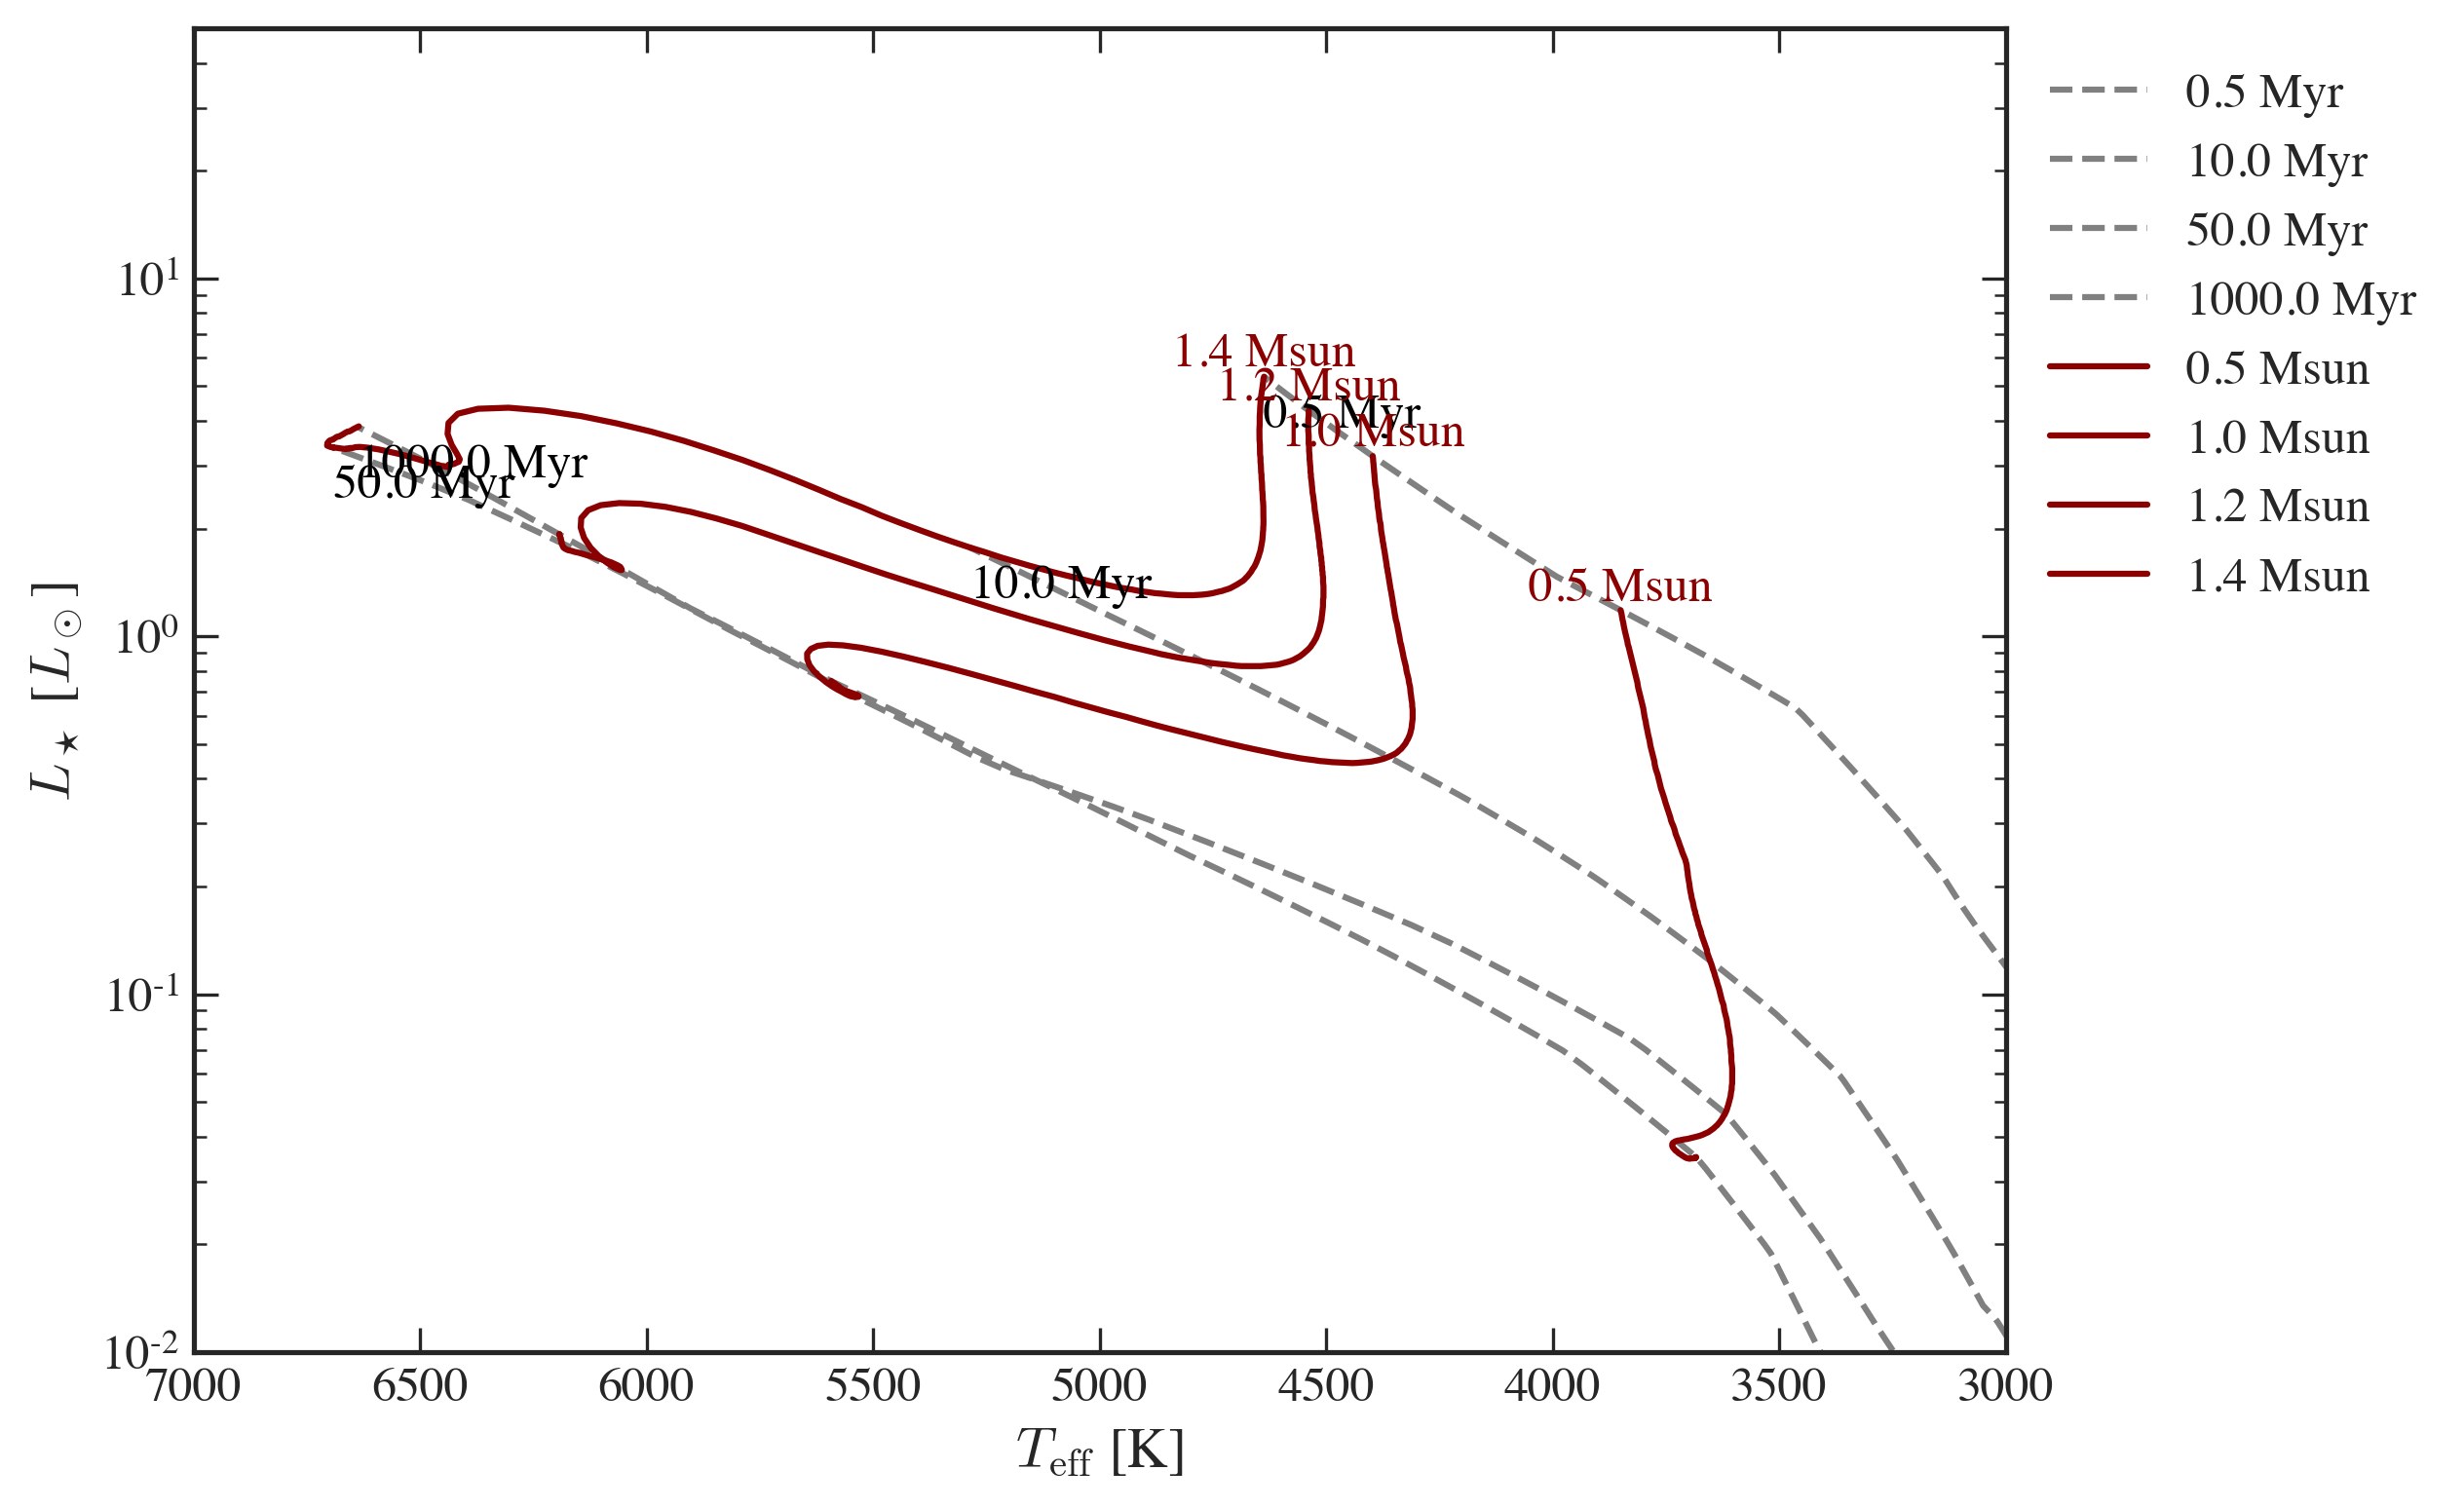

In [63]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

# isochrone.set_tracks('Baraffe2015')

mat_file_dir = './isochrones_data/Baraffe_AgeMassGrid_YSO_up1Gyr_matrix.mat'
isochrone.set_tracks('customize', load_file=mat_file_dir)

fig, ax = plt.subplots(figsize=(8, 6))

# ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
#                                       ages_to_plot=[0.5e6, 1.0e6, 2.0e6, 3.0e6, 5.0e6, 10.0e6, 30.0e6, 100.0e6], 
#                                       masses_to_plot=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.39],
#                                       xlim_set=[6000, 3000], ylim_set=[0.01, 50.0])

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[0.5e6, 10.0e6, 50.0e6, 1000.0e6], 
                                      masses_to_plot=[0.5, 1.0, 1.2, 1.39],
                                      xlim_set=[7000, 3000], ylim_set=[0.01, 50.0])

# ax.set_xlim(6000, 2800)
# ax.set_ylim(0.005, 50)
plt.show()

## How about PARSEC

In [92]:
def find_zams_index(teff_track, lum_track, age_track):
    """
    Finds the index corresponding to the Zero-Age Main Sequence (ZAMS) for a given stellar track.

    Args:
    ------------
    teff_track: [array]
        Array of effective temperatures (Teff) for the stellar track.
    lum_track: [array]
        Array of luminosities (L/Lo) for the stellar track.
    age_track: [array]
        Array of stellar ages for the track.

    Returns:
    ------------
    zams_idx: [int]
        The index corresponding to the ZAMS for the given track.
    """
    
    # Calculate the change in Teff, Luminosity, and age with respect to the previous step
    delta_teff = np.diff(teff_track)
    delta_lum = np.diff(lum_track)
    delta_age = np.diff(age_track)
    
    dteff_dage = delta_teff/delta_age
    dlum_dage = delta_lum/delta_age
    
    # Initialize ZAMS index to None
    zams_idx = None
    
    # Loop over the evolutionary track to identify ZAMS
    for j in range(1, len(delta_teff) - 1):
        # ZAMS condition:
        # 1. Temperature stops increasing or starts decreasing significantly (delta_teff < 0)
        # 2. Luminosity is increasing slowly or stabilizing
        # 3. Age evolution has slowed
        if (delta_teff[j] <= 0) and (delta_lum[j] >= 0):
            if (np.abs(dteff_dage[j]) < np.abs(dteff_dage[0])) and (np.abs(dlum_dage[j]) < np.abs(dlum_dage[0])):
                # Slowing evolution after pre-main-sequence
                zams_idx = j
                break
    
    # If no clear ZAMS point is found, assume the last point is ZAMS
    if zams_idx is None:
        zams_idx = len(teff_track) - 1
    
    return zams_idx

def find_zams_curve(isochrone):
    """
    Find the Zero-Age Main Sequence (ZAMS) curve and mask the isochrone data beyond the ZAMS.

    Args:
    ------------
    isochrone: object of Isochrone class
        Contains the isochrone evolutionary track data (including Teff, Luminosity, and Masses).

    Returns:
    ------------
    teff_zams: [array]
        Array of effective temperatures (Teff) corresponding to ZAMS for each mass track.
    lum_zams: [array]
        Array of luminosities (L/Lo) corresponding to ZAMS for each mass track.
    mask_pms: [2D boolean array]
        Boolean mask that is `True` for pre-main-sequence (PMS) data and `False` for post-ZAMS data.
    """

    logtlogl = isochrone.logtlogl  # log(Teff), log(L/Lo) data
    masses = isochrone.masses      # Stellar masses
    log_ages = isochrone.log_age   # Stellar ages

    # Prepare outputs
    teff_zams = []
    lum_zams = []
    mask_pms = np.ones(logtlogl.shape[:2], dtype=bool)  # Initialize mask to True (PMS phase)

    # Loop over each mass track
    for i, mass in enumerate(masses):
        # Extract Teff, L/Lo, and age for the given mass track
        teff_track = 10**logtlogl[:, i, 0]  # Teff for this mass
        lum_track = 10**logtlogl[:, i, 1]   # Luminosity for this mass
        age_track = 10**log_ages            # Age for this track in years

        # Use the helper function to find the ZAMS index for this mass track
        zams_idx = find_zams_index(teff_track, lum_track, age_track)

        # Store the ZAMS Teff and L/Lo
        teff_zams.append(teff_track[zams_idx])
        lum_zams.append(lum_track[zams_idx])

        # Mask out everything beyond ZAMS (for post-main-sequence phase)
        mask_pms[zams_idx:, i] = False  # Everything beyond ZAMS is False (not part of PMS)

    # Convert lists to numpy arrays for easy plotting
    teff_zams = np.array(teff_zams)
    lum_zams = np.array(lum_zams)

    return teff_zams, lum_zams, mask_pms

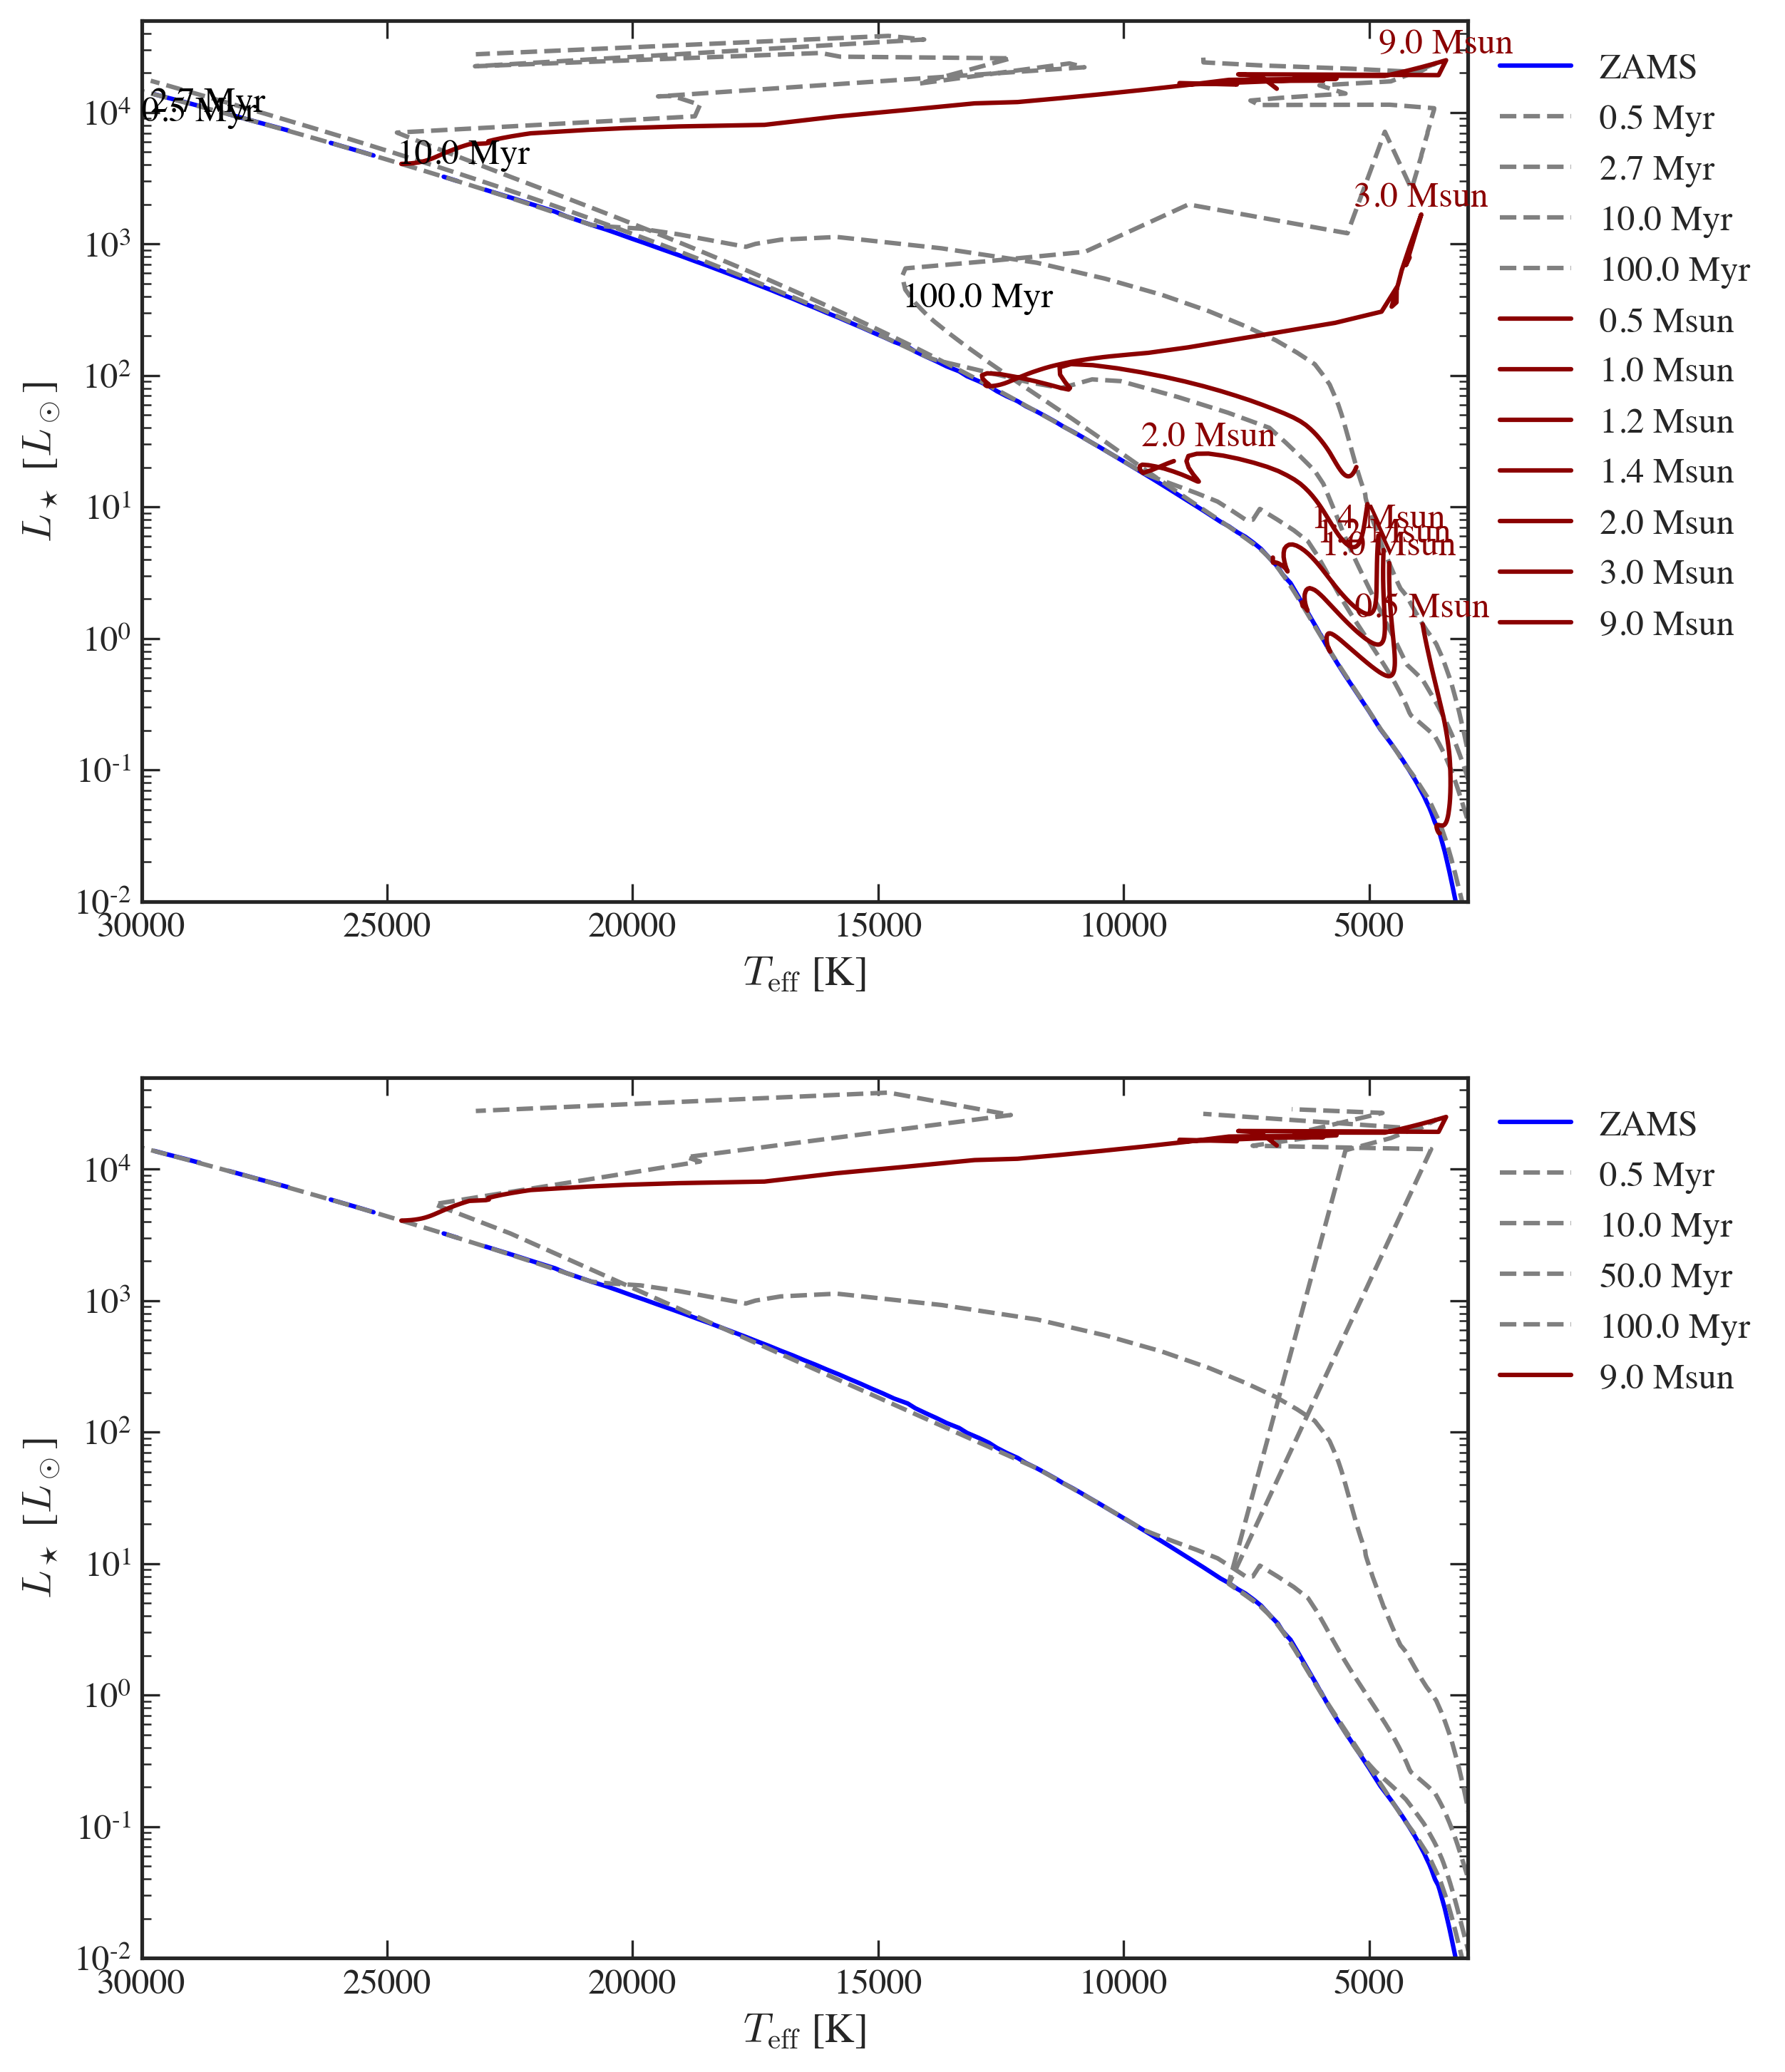

In [155]:
# Initialize the isochrone class with default data directory
isochrone = ysoisochrone.isochrone.Isochrone()

isochrone.set_tracks('PARSEC_v2p0')

# find the ZAMS
teff_zams, lum_zams, mask_pms = find_zams_curve(isochrone)

fig, axes = plt.subplots(2,1,figsize=(8, 12))

ax = axes[0]

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
#                                       ages_to_plot=[0.5e6, 1.0e6, 2.0e6, 3.0e6, 5.0e6, 10.0e6, 30.0e6, 100.0e6], 
#                                       masses_to_plot=[0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.39],
#                                       xlim_set=[6000, 3000], ylim_set=[0.01, 50.0])

ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[0.5e6, 2.7e6, 10.0e6, 100.0e6], 
                                      masses_to_plot=[0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 9.0],
                                      xlim_set=[3e4, 3000], ylim_set=[0.01, 5e4])

ax = axes[1]

# Plot ZAMS curve
ax.plot(teff_zams, lum_zams, 'b-', label='ZAMS')

# Apply the mask to your plotting code
teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo

for age in [0.5e6, 1e7, 5e7, 1e8]:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]

    # Plot the pre-main-sequence part of the isochrone
    ax.plot(teff_filtered, lum_filtered, '--', label=f'{age/1e6:.1f} Myr', color='grey')

# Plot the mass tracks as well (like you already have)
for mass in [9.0]: # 0.5, 1.0, 1.2, 1.4, 2.0, 3.0, 5.0, 10.0, 
    idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass
    teff_filtered = teff_iso[:, idx_mass][mask_pms[:, idx_mass]]
    lum_filtered = lum_iso[:, idx_mass][mask_pms[:, idx_mass]]
    ax.plot(teff_filtered, lum_filtered, '-', label=f'{mass:.1f} Msun', color='darkred')
    
ysoisochrone.plotting.plot_hr_diagram(isochrone, ax_set=ax, 
                                      ages_to_plot=[], 
                                      masses_to_plot=[],
                                      xlim_set=[3e4, 3000], ylim_set=[0.01, 5e4])

plt.show()

In [129]:
for age in [1e8]:  # Example isochrone ages to plot
    idx_age = np.nanargmin(np.abs(isochrone.log_age - np.log10(age)))  # Find the closest age

    # Filter out Teff and Luminosity using the pre-main-sequence mask
    teff_filtered = teff_iso[idx_age, :][mask_pms[idx_age, :]]
    lum_filtered = lum_iso[idx_age, :][mask_pms[idx_age, :]]


In [137]:
lum_filtered[-10]

13959.060216548793

In [140]:
isochrone.masses[-1]

11.594245965238258

In [109]:
teff_filtered

array([2542.47732889, 2556.54075772, 2571.01229868, 2585.90573077,
       2601.23539237, 2615.54200237, 2628.38748306, 2641.62614575,
       2655.24220758, 2669.24808529, 2683.65668447, 2698.48142263,
       2713.73625351, 2726.62861828, 2737.10323104, 2747.86348624,
       2758.91817209, 2770.29392559, 2782.02076472, 2794.07214708,
       2806.02904971, 2818.21611   , 2830.74183943, 2843.61241302,
       2856.82737906, 2870.36853601, 2880.58976612, 2891.08675915,
       2901.86900596, 2912.95028815, 2924.33349359, 2936.02789883,
       2948.04311584, 2960.38910647, 2973.0761977 , 2985.0585122 ,
       2995.10361939, 3005.41770142, 3016.00879894, 3026.88523309,
       3038.05561712, 3049.54721492, 3061.36653787, 3073.50859151,
       3085.98332518, 3096.54847962, 3106.05645308, 3115.81611866,
       3125.83486285, 3136.11865206, 3146.6645672 , 3157.49284096,
       3168.61191282, 3179.32075009, 3190.02529719, 3201.01649671,
       3212.30291869, 3223.89343219, 3235.79428973, 3247.94477

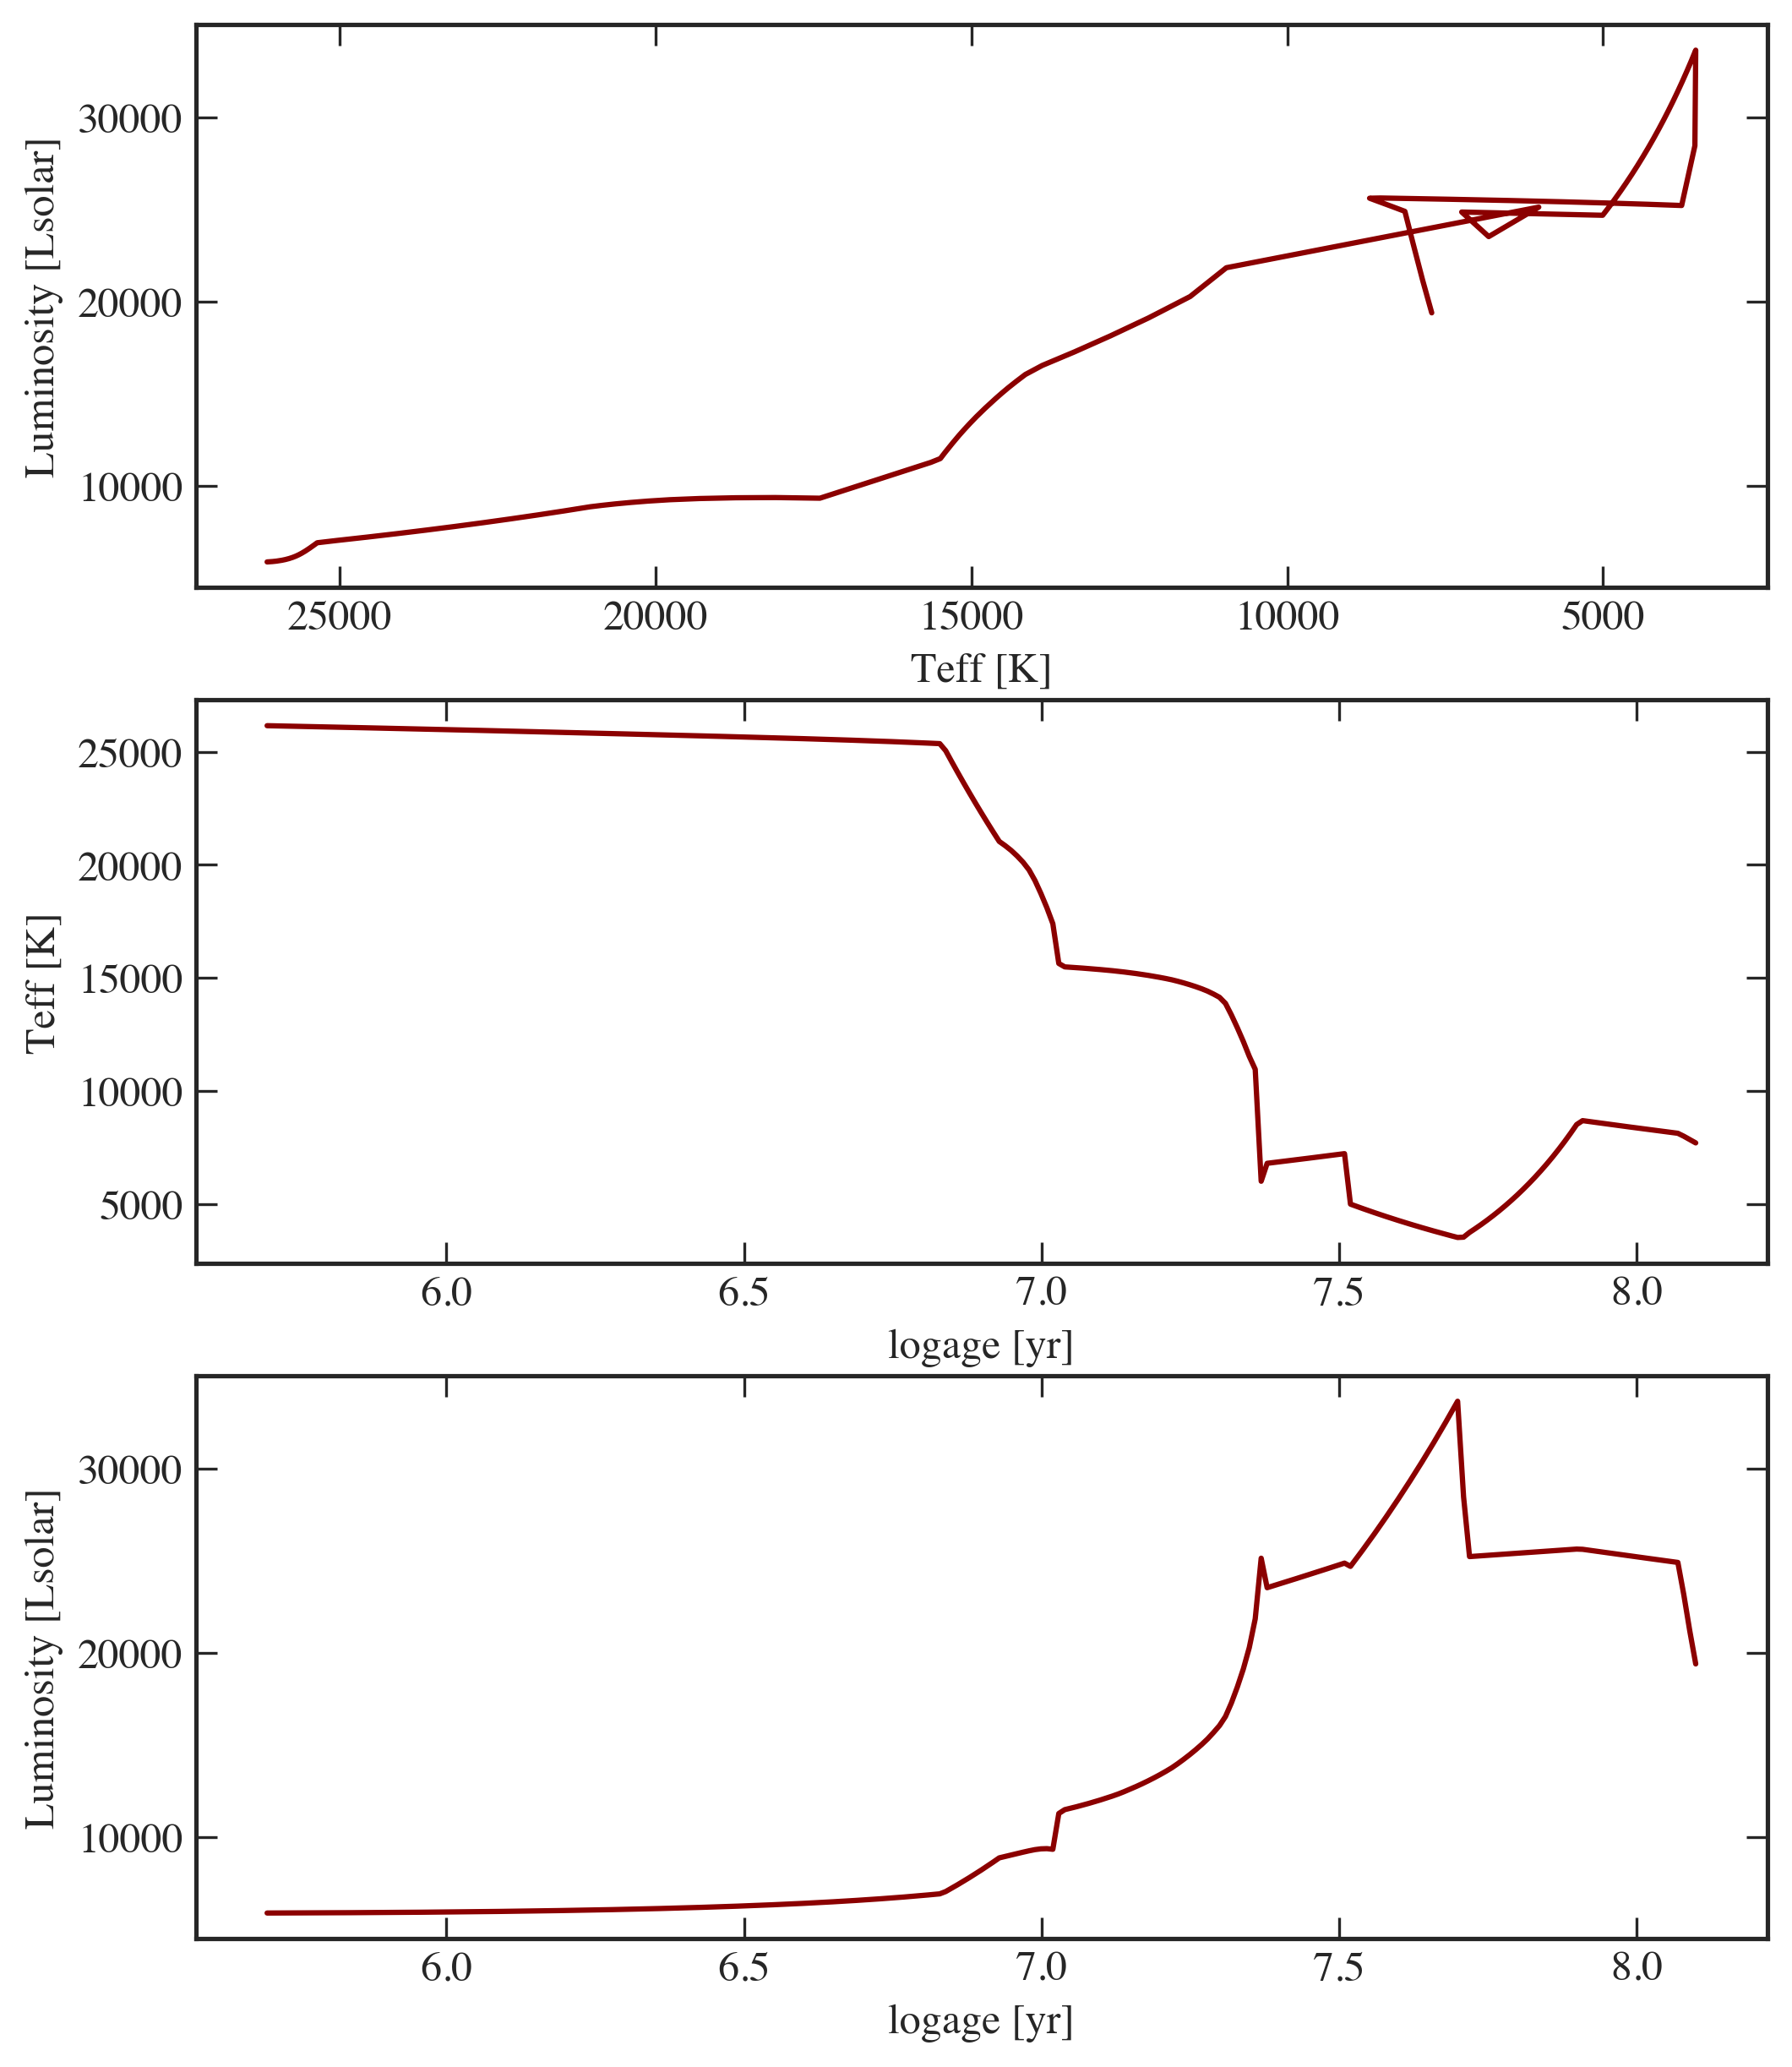

In [128]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo
mass = 10 # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

ax = axes[0]
ax.plot(teff_iso[:, idx_mass], lum_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('Teff [K]')
ax.set_ylabel('Luminosity [Lsolar]')

ax.invert_xaxis()
# ax.set_yscale('log')

ax = axes[1]
ax.plot(isochrone.log_age, teff_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age, lum_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

plt.show()

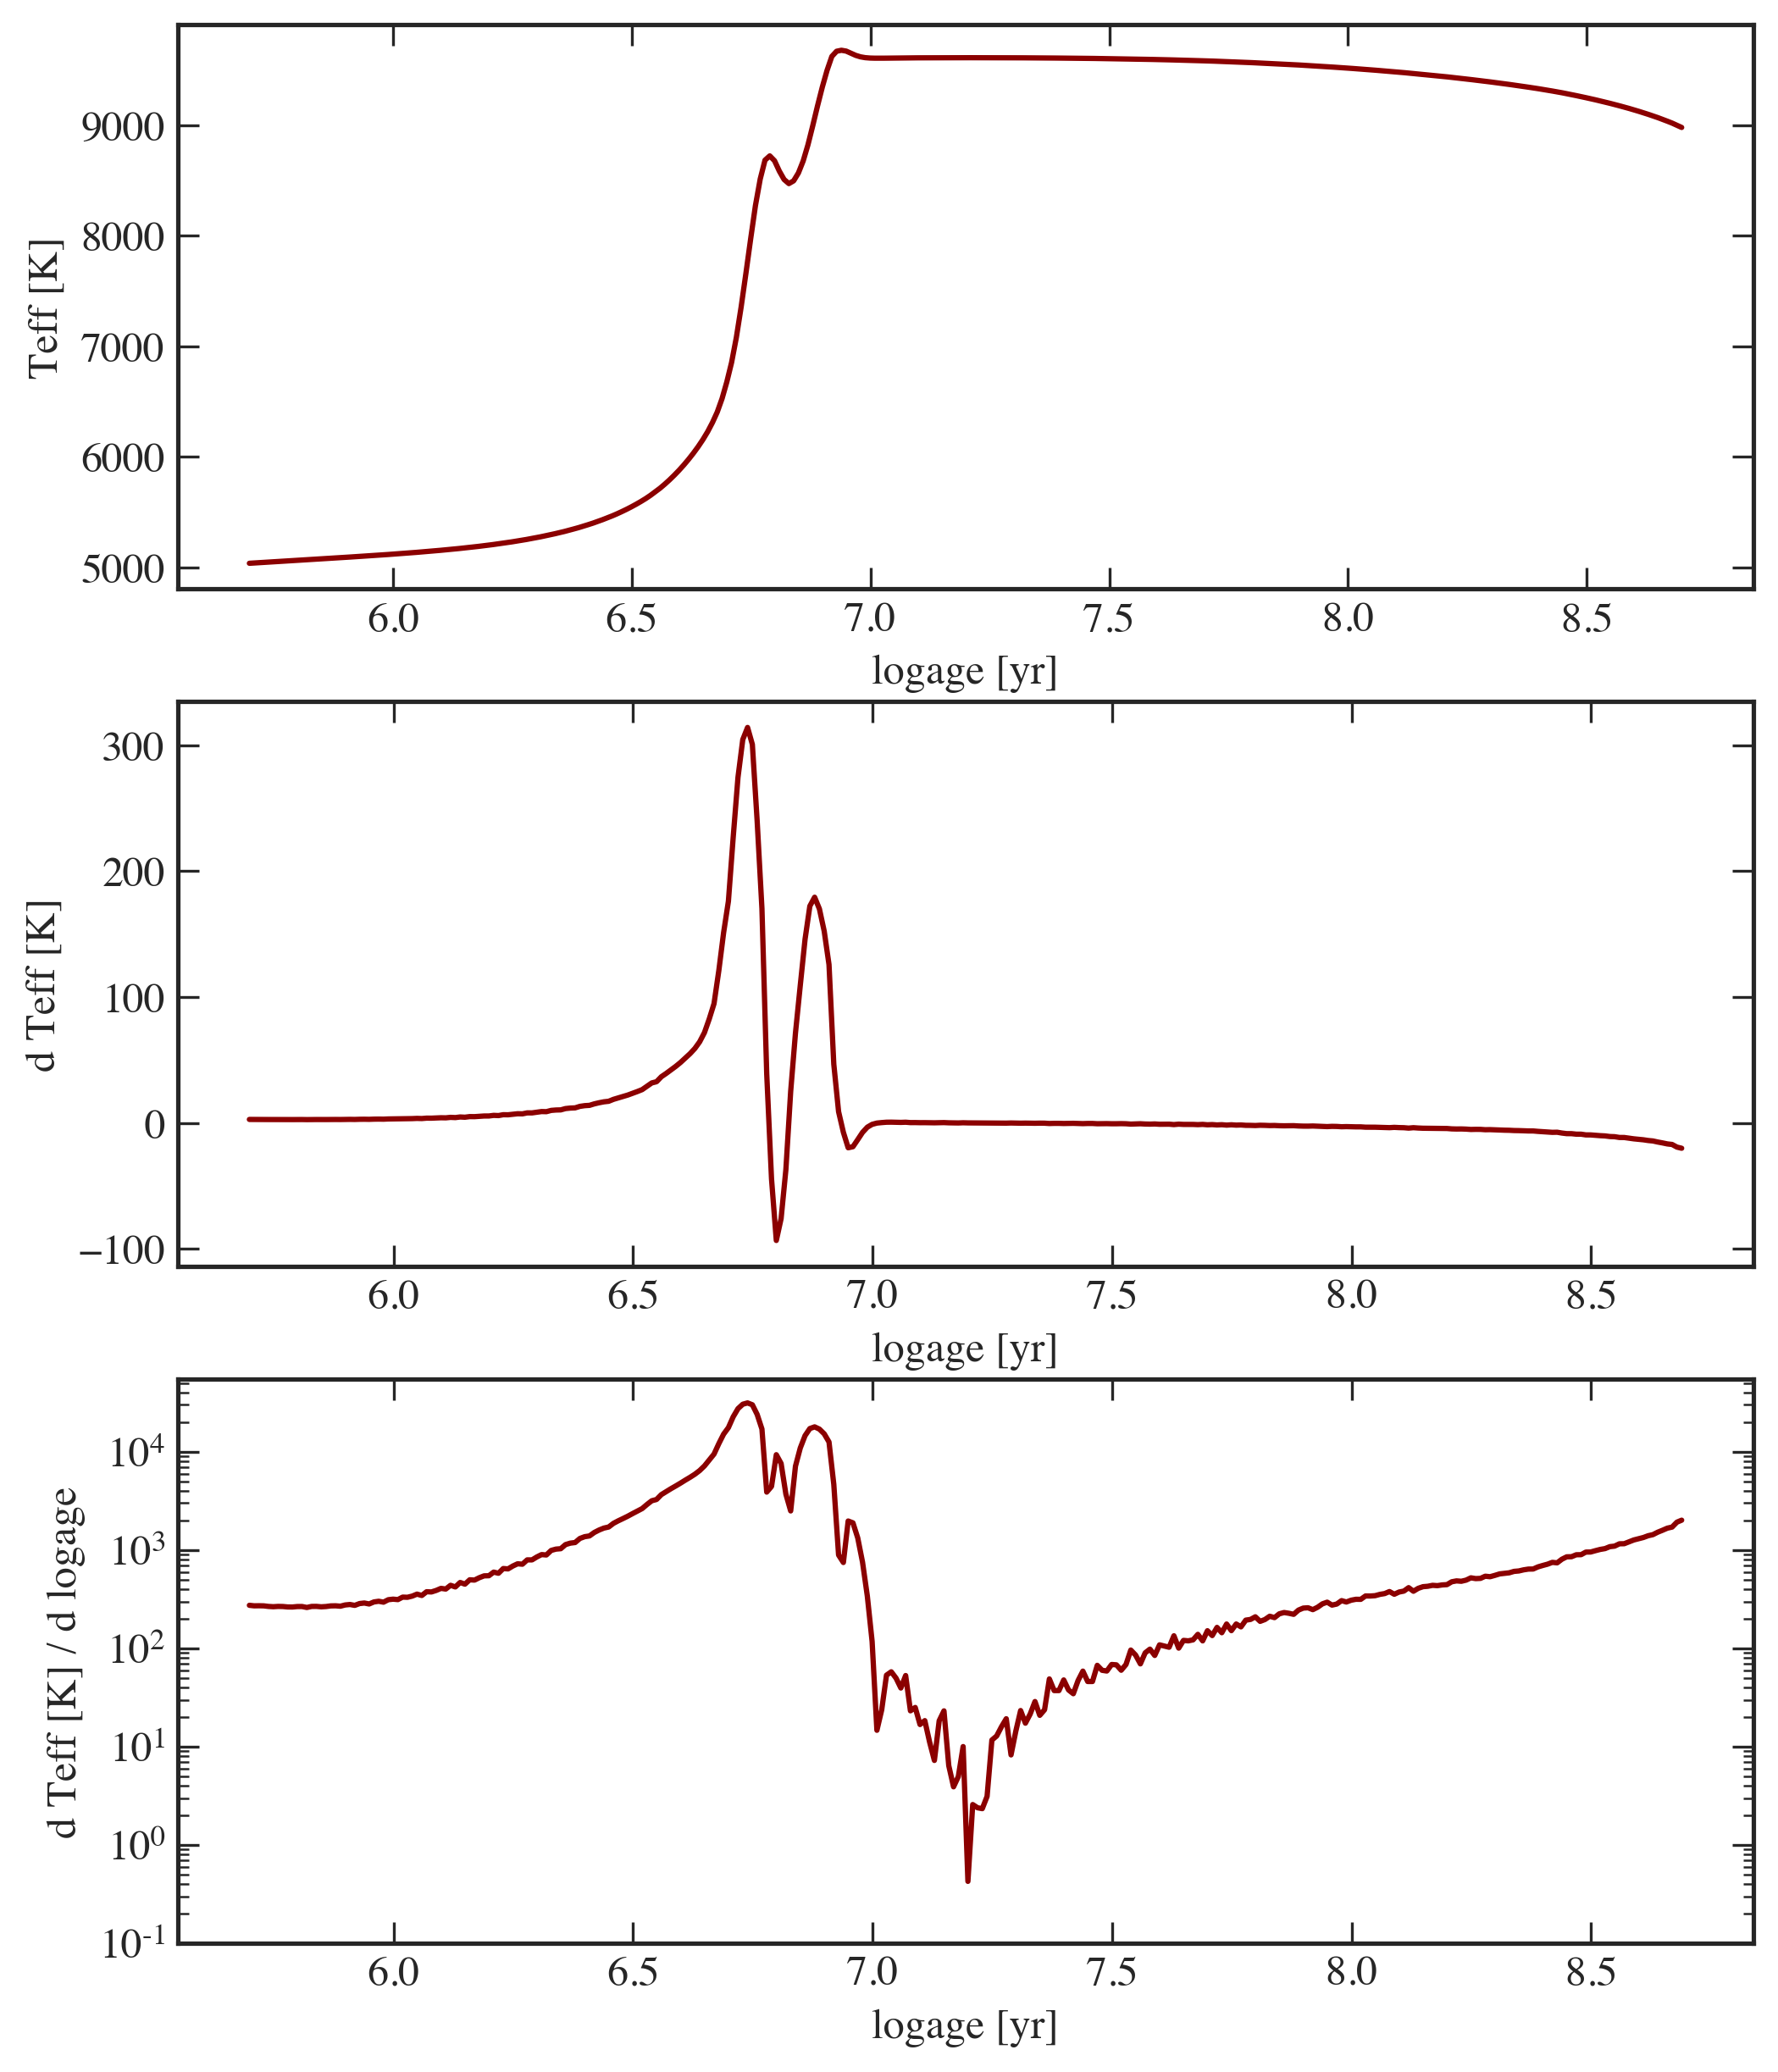

In [87]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

teff_iso = 10**isochrone.logtlogl[:, :, 0]  # Teff
lum_iso = 10**isochrone.logtlogl[:, :, 1]   # L/Lo
mass = 2.0 # solar masses
idx_mass = np.nanargmin(np.abs(isochrone.masses - mass))  # Find closest mass

ax = axes[0]
ax.plot(isochrone.log_age, teff_iso[:, idx_mass], '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[1]
ax.plot(isochrone.log_age[:-1], np.diff(teff_iso[:, idx_mass]), '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('d Teff [K]')
# ax.set_ylabel('Luminosity [Lsolar]')

# ax.set_yscale('log')

ax = axes[2]
ax.plot(isochrone.log_age[:-1], np.abs(np.diff(teff_iso[:, idx_mass])/np.diff(isochrone.log_age)), '-', label=f'{mass:.1f} Msun', color='darkred')

ax.set_xlabel('logage [yr]')
ax.set_ylabel('d Teff [K] / d logage')
# ax.set_ylabel('Luminosity [Lsolar]')

ax.set_yscale('log')
ax.set_ylim(1e-1, )

plt.show()